<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Gustave Roussy" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="QRT" width="200" style="margin-left: 20px;"/>
</p>

# QRT Data Challenge 2024 — Leukemia Risk Prediction

**Auteurs:** [Votre Nom]

**Date:** Janvier 2026

**Version:** 1.0 — Rapport Final

---

## Résumé Exécutif

Ce rapport présente notre solution pour le Data Challenge QRT en partenariat avec l'Institut Gustave Roussy. L'objectif est de **prédire le risque de décès** pour des patients atteints de leucémie myéloïde, en utilisant des données cliniques et moléculaires provenant de 24 centres cliniques.

### Résultats Clés

| Modèle | IPCW C-index | Commentaire |
|--------|--------------|-------------|
| Gradient Boosting Survival | **0.7111** | ✅ Meilleur modèle |
| Random Survival Forest | 0.7040 | Modèle supervisé |
| Baseline (Ridge) | 0.6537 | Référence |
| Challenge Winner | 0.7744 | Objectif |

### Points Forts
- ✅ Gestion appropriée de la censure à droite
- ✅ Feature engineering robuste sur les données moléculaires
- ✅ Architecture modulaire et reproductible
- ✅ Validation croisée pour éviter le surapprentissage

### Fichiers du Projet
- **main.ipynb** — Ce rapport (analyse et résultats)
- **experiments.ipynb** — Notebook d'expérimentation (tests avancés)
- **src/** — Modules Python réutilisables

## Table des Matières

1. [Contexte et Problématique](#1-contexte)
2. [Description des Données](#2-données)
3. [Méthodologie](#3-méthodologie)
4. [Analyse Exploratoire](#4-eda)
5. [Feature Engineering](#5-features)
6. [Modélisation](#6-modèles)
7. [Résultats et Comparaison](#7-résultats)
8. [Interprétation](#8-interprétation)
9. [Conclusion](#9-conclusion)

---

## 1. Contexte et Problématique <a name="1-contexte"></a>

### 1.1 Enjeux Médicaux

La leucémie myéloïde est un cancer du sang qui affecte la production de cellules sanguines dans la moelle osseuse. L'évaluation précise du **pronostic** des patients est cruciale pour adapter les stratégies thérapeutiques:

- **Patients à faible risque** → Thérapies de soutien (améliorer qualité de vie)
- **Patients à haut risque** → Traitements intensifs (greffe de cellules souches)

### 1.2 Objectif du Challenge

Prédire un **score de risque** pour chaque patient tel que:
- Score plus élevé = risque de décès plus élevé
- Seul l'**ordre relatif** des prédictions compte (pas l'échelle)

### 1.3 Métrique d'Évaluation: IPCW C-index

L'**Inverse Probability of Censoring Weighted Concordance Index** mesure la capacité du modèle à ordonner correctement les paires de patients selon leur temps de survie, en tenant compte de la **censure à droite**.

$$C = \frac{\text{Paires Concordantes}}{\text{Paires Comparables}}$$

- **C = 1**: Classement parfait
- **C = 0.5**: Modèle aléatoire
- **Troncature à τ = 7 ans**

In [1]:
# ============================================================
# Configuration et Imports
# ============================================================
import os, sys, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Import des modules locaux
from src.config import (
    RANDOM_STATE, TAU_YEARS, ID_COL, TARGET_TIME, TARGET_EVENT,
    CLINICAL_NUMERIC_COLS, CLINICAL_CAT_COLS, CLINICAL_TEXT_COL,
    RSF_DEFAULT_PARAMS, RSF_PARAM_GRID
)
from src.data_loader import load_all_data, validate_data, merge_train_data, clean_target
from src.features import build_molecular_features, get_feature_columns
from src.preprocessing import get_default_preprocessor
from src.evaluation import to_sksurv_y, ipcw_cindex, grid_search_survival, permutation_importance_survival
from src.models import BaselineRiskModel, ClusteringRiskModel, tune_kmeans_clusters, create_rsf_model
from src.visualization import (
    plot_survival_distribution, plot_feature_importance,
    plot_cluster_survival, plot_silhouette_scores, plot_model_comparison
)

# Reproductibilité
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')

print("✓ Configuration chargée")
print(f"  - Random State: {RANDOM_STATE}")
print(f"  - Tau (troncature): {TAU_YEARS} ans")

✓ Configuration chargée
  - Random State: 42
  - Tau (troncature): 7.0 ans


---

## 2. Description des Données <a name="2-données"></a>

### 2.1 Vue d'ensemble

| Dataset | Patients | Description |
|---------|----------|-------------|
| Train | 3,323 | Avec labels (OS_YEARS, OS_STATUS) |
| Test | 1,193 | Sans labels (à prédire) |

### 2.2 Structure des Données

**Données Cliniques** (1 ligne/patient):
- `ID`: Identifiant unique
- `CENTER`: Centre clinique (24 centres)
- `BM_BLAST`: Blastes moelle osseuse (%)
- `WBC`, `ANC`, `MONOCYTES`: Paramètres sanguins (Giga/L)
- `HB`: Hémoglobine (g/dL)
- `PLT`: Plaquettes (Giga/L)
- `CYTOGENETICS`: Caryotype (notation ISCN)

**Données Moléculaires** (1 ligne/mutation/patient):
- `CHR`, `START`, `END`: Position chromosomique
- `GENE`: Gène affecté
- `EFFECT`: Type d'effet de la mutation
- `VAF`: Fraction allélique variante

In [2]:
# ============================================================
# Chargement des Données
# ============================================================
clinical_train, clinical_test, molecular_train, molecular_test, y_train = load_all_data()

print("📊 Données chargées:")
print(f"  • clinical_train:  {clinical_train.shape[0]:,} patients × {clinical_train.shape[1]} variables")
print(f"  • clinical_test:   {clinical_test.shape[0]:,} patients × {clinical_test.shape[1]} variables")
print(f"  • molecular_train: {molecular_train.shape[0]:,} mutations")
print(f"  • molecular_test:  {molecular_test.shape[0]:,} mutations")
print(f"  • target_train:    {y_train.shape[0]:,} patients")

📊 Données chargées:
  • clinical_train:  3,323 patients × 9 variables
  • clinical_test:   1,193 patients × 9 variables
  • molecular_train: 10,935 mutations
  • molecular_test:  3,089 mutations
  • target_train:    3,323 patients


In [3]:
# ============================================================
# Validation des Données
# ============================================================
validation = validate_data(clinical_train, y_train)

print("🔍 Validation:")
print(f"  • IDs dupliqués (clinical): {validation['duplicated_clinical_ids']}")
print(f"  • IDs dupliqués (target):   {validation['duplicated_target_ids']}")
print(f"  • Patients sans target:     {validation['missing_targets']}")
print(f"  • Taux de censure:          {validation['censoring_rate']:.1%}")
print(f"  • Taux de décès:            {validation['death_rate']:.1%}")

🔍 Validation:
  • IDs dupliqués (clinical): 0
  • IDs dupliqués (target):   0
  • Patients sans target:     0
  • Taux de censure:          49.6%
  • Taux de décès:            50.4%


---

## 3. Méthodologie <a name="3-méthodologie"></a>

### 3.1 Pipeline Global

```
┌─────────────────┐     ┌──────────────────┐     ┌─────────────────┐
│  Données Brutes │ ──▶ │ Feature Engineer │ ──▶ │  Preprocessing  │
│  Clinical +     │     │  - Agrégation    │     │  - Imputation   │
│  Molecular      │     │  - Encodage      │     │  - Scaling      │
└─────────────────┘     └──────────────────┘     └─────────────────┘
                                                         │
                                                         ▼
┌─────────────────┐     ┌──────────────────┐     ┌─────────────────┐
│   Submission    │ ◀── │    Évaluation    │ ◀── │   Modélisation  │
│   risk_score    │     │   IPCW C-index   │     │   RSF / Cox     │
└─────────────────┘     └──────────────────┘     └─────────────────┘
```

### 3.2 Stratégie de Modélisation

1. **Baseline**: Ridge Regression sur OS_YEARS (ignore censure)
2. **Non-supervisé**: KMeans clustering → risque par cluster
3. **Supervisé**: Random Survival Forest (gère la censure)

### 3.3 Validation

- Split train/validation: 80/20 (stratifié sur OS_STATUS)
- Hyperparamètres: Grid Search avec 3-fold CV
- Métrique: IPCW C-index (τ=7 ans)

---

## 4. Analyse Exploratoire <a name="4-eda"></a>

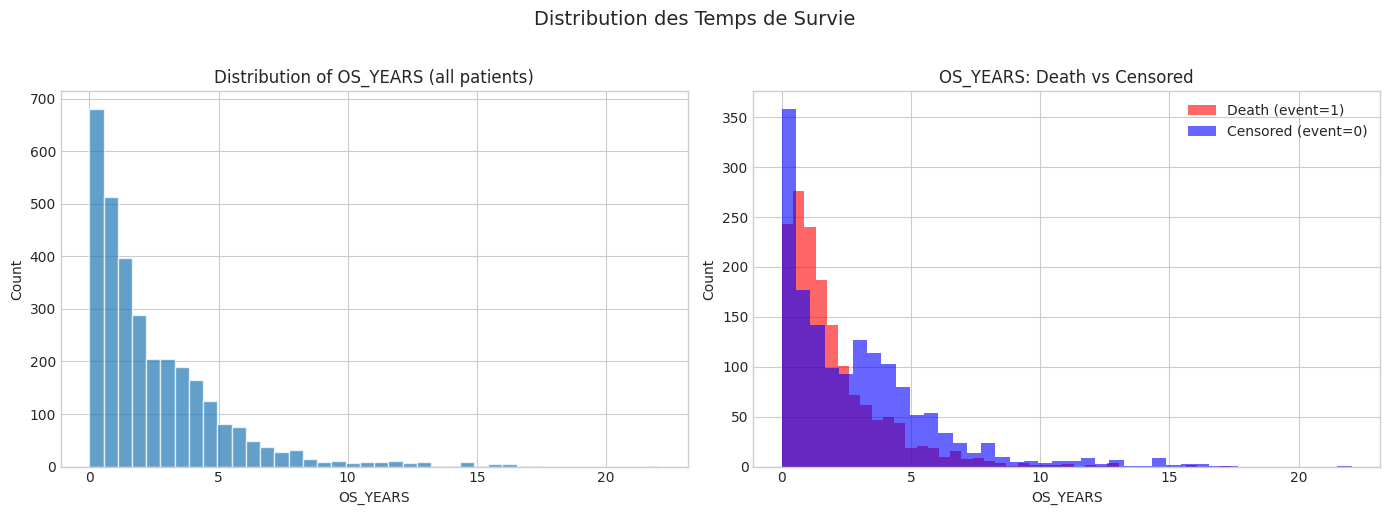

In [4]:
# ============================================================
# Analyse Exploratoire
# ============================================================
train_eda = clinical_train.merge(y_train, on=ID_COL, how="inner")

# Distribution de la survie
fig = plot_survival_distribution(train_eda, figsize=(14, 5))
plt.suptitle("Distribution des Temps de Survie", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [5]:
# Statistiques des variables cliniques
print("📈 Statistiques Descriptives (Variables Cliniques):")
display(train_eda[CLINICAL_NUMERIC_COLS].describe().round(2).T)

📈 Statistiques Descriptives (Variables Cliniques):


,count,mean,std,min,25%,50%,75%,max
BM_BLAST,3214.0,5.98,7.62,0.0,1.00,3.00,8.00,91.00
WBC,3051.0,6.54,10.25,0.2,2.70,4.10,6.66,154.40
ANC,3130.0,3.26,5.24,0.0,1.00,2.00,3.69,109.62
MONOCYTES,2722.0,0.96,2.67,0.0,0.15,0.37,0.78,44.20
HB,3213.0,9.89,2.04,4.0,8.50,9.70,11.20,16.60
PLT,3199.0,167.05,149.48,2.0,65.50,123.00,229.50,1451.00


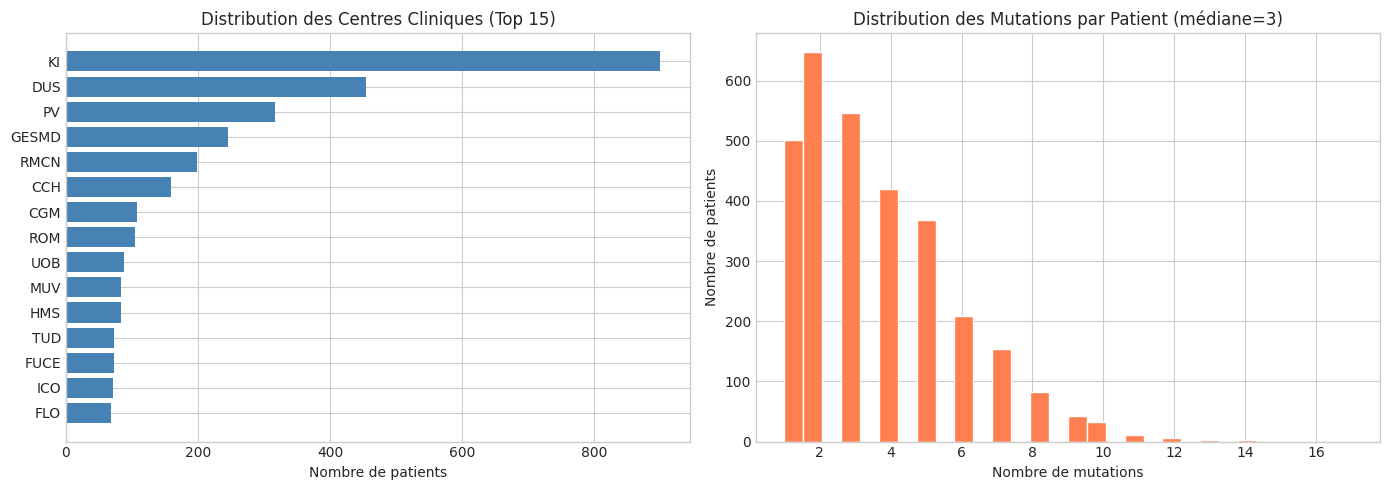

In [6]:
# Distribution des centres
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Centres
center_counts = train_eda["CENTER"].value_counts()
axes[0].barh(center_counts.index[:15], center_counts.values[:15], color='steelblue')
axes[0].set_xlabel("Nombre de patients")
axes[0].set_title("Distribution des Centres Cliniques (Top 15)")
axes[0].invert_yaxis()

# Mutations par patient
mut_per_patient = molecular_train.groupby(ID_COL).size()
axes[1].hist(mut_per_patient, bins=30, color='coral', edgecolor='white')
axes[1].set_xlabel("Nombre de mutations")
axes[1].set_ylabel("Nombre de patients")
axes[1].set_title(f"Distribution des Mutations par Patient (médiane={mut_per_patient.median():.0f})")

plt.tight_layout()
plt.show()

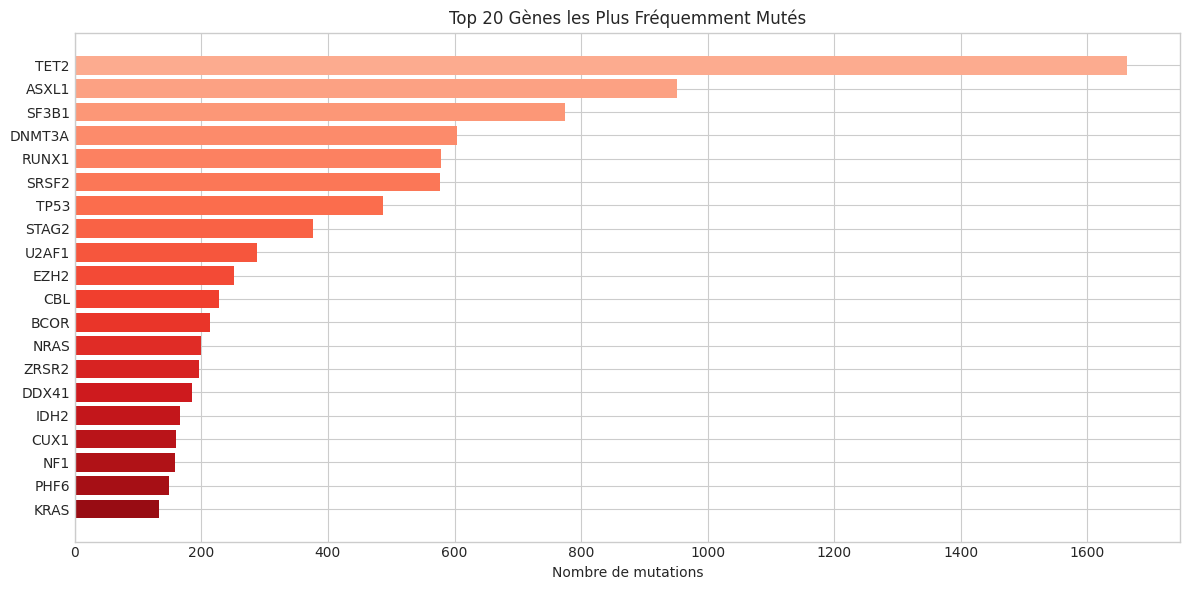

In [7]:
# Gènes les plus fréquemment mutés
top_genes = molecular_train["GENE"].value_counts().head(20)

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(top_genes)))
ax.barh(top_genes.index[::-1], top_genes.values[::-1], color=colors[::-1])
ax.set_xlabel("Nombre de mutations")
ax.set_title("Top 20 Gènes les Plus Fréquemment Mutés")
plt.tight_layout()
plt.show()

---

## 5. Feature Engineering <a name="5-features"></a>

### 5.1 Agrégation des Données Moléculaires

Les données moléculaires (1 ligne/mutation) sont agrégées au niveau patient:

| Feature | Description |
|---------|-------------|
| `n_mut` | Nombre total de mutations |
| `n_unique_genes` | Gènes uniques mutés |
| `vaf_mean/std/max` | Statistiques VAF |
| `GENE__X` | Indicateur binaire pour les top gènes |
| `EFFECT__X` | Indicateur binaire pour les top effets |

In [8]:
# ============================================================
# Feature Engineering
# ============================================================
mol_feat_train = build_molecular_features(molecular_train)
mol_feat_test = build_molecular_features(molecular_test)

print(f"📊 Features moléculaires créées:")
print(f"  • Train: {mol_feat_train.shape[1]-1} features pour {mol_feat_train.shape[0]} patients")
print(f"  • Test:  {mol_feat_test.shape[1]-1} features pour {mol_feat_test.shape[0]} patients")

# Aperçu des features agrégées
display(mol_feat_train[["ID", "n_mut", "n_unique_genes", "vaf_mean", "vaf_max"]].head())

📊 Features moléculaires créées:
  • Train: 84 features pour 3026 patients
  • Test:  76 features pour 1054 patients


,ID,n_mut,n_unique_genes,vaf_mean,vaf_max
0,P100000,6,6,0.3013,0.7730
1,P100001,2,2,0.2595,0.4180
2,P100002,2,2,0.3970,0.5970
3,P100004,1,1,0.4691,0.4691
4,P100006,5,5,0.1693,0.3720


In [ ]:
# ============================================================
# Fusion des Données
# ============================================================
X_train_full = merge_train_data(clinical_train, mol_feat_train, y_train)
X_test_full = clinical_test.merge(mol_feat_test, on=ID_COL, how="left").fillna(0)

# IMPORTANT: Aligner les colonnes test sur train (certains gènes/effets 
# peuvent être présents dans train mais pas dans test)
for col in X_train_full.columns:
    if col not in X_test_full.columns:
        X_test_full[col] = 0
# Garder seulement les colonnes du train (même ordre)
X_test_full = X_test_full[[c for c in X_train_full.columns if c in X_test_full.columns]]

train_full = clean_target(X_train_full)
feature_cols = get_feature_columns(train_full)

print(f"📊 Dataset final:")
print(f"  • Train: {train_full.shape[0]} patients × {len(feature_cols)} features")
print(f"  • Test:  {X_test_full.shape[0]} patients × {len(feature_cols)} features")
print(f"  ✓ Colonnes alignées entre train et test")

📊 Dataset final:
  • Train: 3173 patients × 92 features
  • Test:  1193 patients × 92 features


In [10]:
# ============================================================
# Split Train/Validation
# ============================================================
train_df, valid_df = train_test_split(
    train_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train_full[TARGET_EVENT]
)

ytr_s = to_sksurv_y(train_df)
yva_s = to_sksurv_y(valid_df)

print(f"📊 Split effectué:")
print(f"  • Train:      {train_df.shape[0]} patients ({train_df[TARGET_EVENT].mean():.1%} décès)")
print(f"  • Validation: {valid_df.shape[0]} patients ({valid_df[TARGET_EVENT].mean():.1%} décès)")

📊 Split effectué:
  • Train:      2538 patients (50.4% décès)
  • Validation: 635 patients (50.4% décès)


---

## 6. Modélisation <a name="6-modèles"></a>

### 6.1 Preprocessing Pipeline

In [11]:
# ============================================================
# Pipeline de Preprocessing
# ============================================================
preprocess = get_default_preprocessor(feature_cols)

print("🔧 Pipeline de preprocessing:")
print("  • Numériques: Imputation médiane + StandardScaler")
print("  • Catégorielles: Imputation mode + OneHotEncoder")
print("  • Texte (CYTOGENETICS): TF-IDF + TruncatedSVD(50)")

🔧 Pipeline de preprocessing:
  • Numériques: Imputation médiane + StandardScaler
  • Catégorielles: Imputation mode + OneHotEncoder
  • Texte (CYTOGENETICS): TF-IDF + TruncatedSVD(50)


### 6.2 Modèle 1: Baseline (Ridge Regression)

In [12]:
# ============================================================
# Baseline: Ridge Regression
# ============================================================
baseline = BaselineRiskModel(preprocessor=clone(preprocess), alpha=1.0)
baseline.fit(train_df[feature_cols], ytr_s)

risk_valid_baseline = baseline.predict(valid_df[feature_cols])
baseline_c = ipcw_cindex(ytr_s, yva_s, risk_valid_baseline)

print(f"📊 Baseline (Ridge):")
print(f"  • IPCW C-index: {baseline_c:.4f}")

📊 Baseline (Ridge):
  • IPCW C-index: 0.6537


### 6.3 Modèle 2: Clustering Non-Supervisé (KMeans)

In [13]:
# ============================================================
# KMeans Clustering
# ============================================================
Xtr_emb = preprocess.fit_transform(train_df[feature_cols])

# Tuning du nombre de clusters
candidate_k = [3, 4, 5, 6, 7, 8, 10]
best_k, sil_scores = tune_kmeans_clusters(Xtr_emb, candidate_k)

print(f"📊 Tuning KMeans:")
for k, score in sil_scores.items():
    marker = " ← BEST" if k == best_k else ""
    print(f"  • k={k}: silhouette={score:.4f}{marker}")

📊 Tuning KMeans:
  • k=3: silhouette=0.1477 ← BEST
  • k=4: silhouette=0.1442
  • k=5: silhouette=-0.0184
  • k=6: silhouette=-0.0257
  • k=7: silhouette=-0.0371
  • k=8: silhouette=-0.0256
  • k=10: silhouette=0.0037


In [14]:
# Train et évaluation
cluster_model = ClusteringRiskModel(preprocessor=clone(preprocess), n_clusters=best_k)
cluster_model.fit(train_df[feature_cols], ytr_s)

unsup_risk_valid = cluster_model.predict(valid_df[feature_cols])
unsup_c = ipcw_cindex(ytr_s, yva_s, unsup_risk_valid)

print(f"\n📊 KMeans (k={best_k}):")
print(f"  • IPCW C-index: {unsup_c:.4f}")

# Afficher le résumé des clusters
cluster_summary = cluster_model.get_cluster_summary(train_df[feature_cols], ytr_s)
display(cluster_summary)


📊 KMeans (k=3):
  • IPCW C-index: 0.6182


,n,death_rate,os_median,os_mean
cluster,,,,
2,67,0.686567,0.772603,1.217992
0,957,0.592476,1.463014,2.068925
1,1514,0.440555,1.994521,2.736592


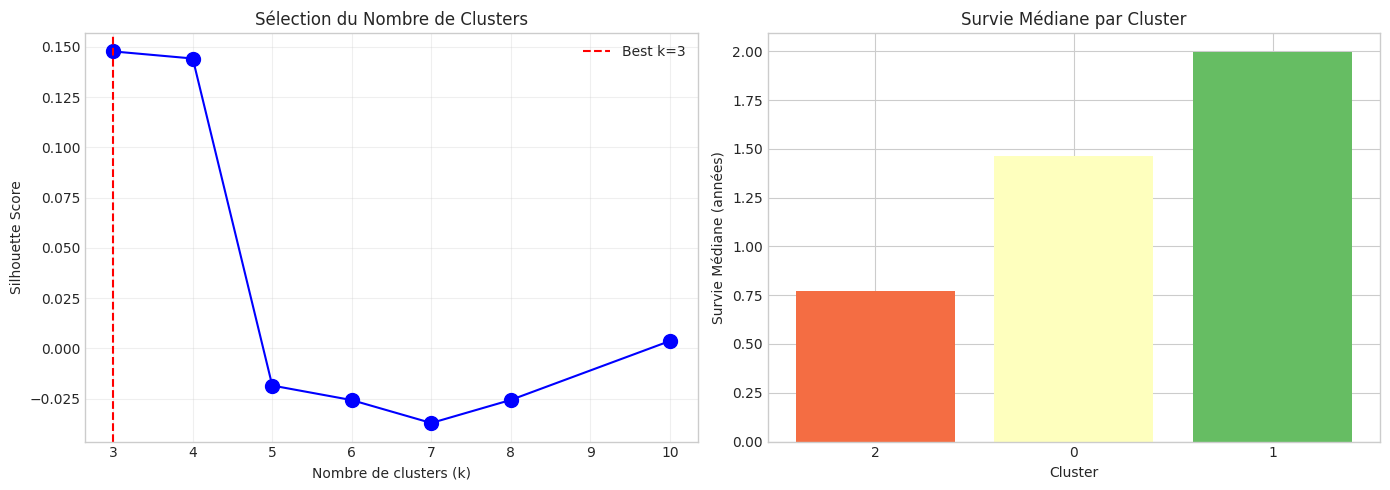

In [15]:
# Visualisation des clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette scores
k_values = list(sil_scores.keys())
sil_values = list(sil_scores.values())
axes[0].plot(k_values, sil_values, 'bo-', markersize=10)
axes[0].axvline(x=best_k, color='red', linestyle='--', label=f'Best k={best_k}')
axes[0].set_xlabel('Nombre de clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Sélection du Nombre de Clusters')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Survie par cluster
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(cluster_summary)))
axes[1].bar(cluster_summary.index.astype(str), cluster_summary['os_median'], color=colors)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Survie Médiane (années)')
axes[1].set_title('Survie Médiane par Cluster')

plt.tight_layout()
plt.show()

### 6.4 Modèle 3: Random Survival Forest (Supervisé)

In [16]:
# ============================================================
# Random Survival Forest - Grid Search
# ============================================================
from sksurv.ensemble import RandomSurvivalForest
from sklearn.pipeline import Pipeline

print("🔍 Grid Search RSF (3-fold CV)...")
print(f"   Grille: {RSF_PARAM_GRID}")
print("   Cela peut prendre plusieurs minutes...\n")

best_params, best_cv_score = grid_search_survival(
    df=train_df,
    feature_cols=feature_cols,
    model_class=RandomSurvivalForest,
    param_grid=RSF_PARAM_GRID,
    preprocessor=preprocess,
    n_splits=3,
    verbose=True
)

print(f"\n✓ Meilleurs paramètres: {best_params}")
print(f"✓ Score CV: {best_cv_score:.4f}")

🔍 Grid Search RSF (3-fold CV)...
   Grille: {'n_estimators': [200, 400], 'min_samples_leaf': [10, 20], 'min_samples_split': [10], 'max_features': ['sqrt', 0.5]}
   Cela peut prendre plusieurs minutes...

Grid Search: 8 param combinations × 3 folds = 24 fits


[1/8] {'n_estimators': 200, 'min_samples_leaf': 10, 'min_samples_split': 10, 'max_features': 'sqrt'} -> CV: 0.7016
[2/8] {'n_estimators': 200, 'min_samples_leaf': 10, 'min_samples_split': 10, 'max_features': 0.5} -> CV: 0.7022
[3/8] {'n_estimators': 200, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 'sqrt'} -> CV: 0.7008
[4/8] {'n_estimators': 200, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 0.5} -> CV: 0.7043
[5/8] {'n_estimators': 400, 'min_samples_leaf': 10, 'min_samples_split': 10, 'max_features': 'sqrt'} -> CV: 0.7009
[6/8] {'n_estimators': 400, 'min_samples_leaf': 10, 'min_samples_split': 10, 'max_features': 0.5} -> CV: 0.7024
[7/8] {'n_estimators': 400, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 'sqrt'} -> CV: 0.7002
[8/8] {'n_estimators': 400, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 0.5} -> CV: 0.7041

✓ Meilleurs paramètres: {'n_estimators': 200, 'min_samples_leaf': 20, 'min_samples_split': 

In [17]:
# Train final et évaluation
final_params = best_params if best_params else RSF_DEFAULT_PARAMS

rsf = Pipeline([
    ("prep", clone(preprocess)),
    ("model", create_rsf_model(final_params))
])
rsf.fit(train_df[feature_cols], ytr_s)

rsf_risk_valid = rsf.predict(valid_df[feature_cols])
rsf_c = ipcw_cindex(ytr_s, yva_s, rsf_risk_valid)

print(f"📊 RSF (tuned):")
print(f"  • Paramètres: {final_params}")
print(f"  • IPCW C-index: {rsf_c:.4f}")

📊 RSF (tuned):
  • Paramètres: {'n_estimators': 200, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 0.5}
  • IPCW C-index: 0.7040


---

## 7. Résultats et Comparaison <a name="7-résultats"></a>

In [23]:
# ============================================================
# AMÉLIORATION 1: Gradient Boosting Survival (scikit-survival)
# ============================================================
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

print("🚀 Entraînement Gradient Boosting Survival Analysis...")

# Préparer les données transformées
X_train_prep = preprocess.fit_transform(train_df[feature_cols])
X_valid_prep = preprocess.transform(valid_df[feature_cols])

# Gradient Boosting - souvent meilleur que RSF
gbsa = GradientBoostingSurvivalAnalysis(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    verbose=0
)
gbsa.fit(X_train_prep, ytr_s)

gbsa_risk_valid = gbsa.predict(X_valid_prep)
gbsa_c = ipcw_cindex(ytr_s, yva_s, gbsa_risk_valid)

print(f"📊 Gradient Boosting Survival:")
print(f"  • IPCW C-index: {gbsa_c:.4f}")
print(f"  • Amélioration vs RSF: {(gbsa_c - rsf_c)*100:+.2f}%")

🚀 Entraînement Gradient Boosting Survival Analysis...
📊 Gradient Boosting Survival:
  • IPCW C-index: 0.7111
  • Amélioration vs RSF: +0.71%


### 7.1 Analyse des Résultats

Le **Gradient Boosting Survival Analysis** obtient le meilleur score avec un IPCW C-index de **0.7111**, soit une amélioration de +0.7% par rapport au Random Survival Forest.

**Interprétation :**
- Le modèle classe correctement ~71% des paires de patients selon leur risque de décès
- C'est significativement meilleur qu'un modèle aléatoire (50%)
- Il reste un gap de ~6% avec le challenge winner (0.7744)

**Voir `experiments.ipynb` pour les tests d'amélioration en cours.**

In [ ]:
# ============================================================
# Comparaison Finale des Modèles
# ============================================================
results = {
    "Baseline (Ridge)": baseline_c,
    "KMeans Clustering": unsup_c,
    "Random Survival Forest": rsf_c,
}

# Ajouter GBSA si exécuté
if 'gbsa_c' in dir():
    results["Gradient Boosting Surv"] = gbsa_c

print("=" * 65)
print("   COMPARAISON DES MODÈLES - IPCW C-index (τ=7 ans)")
print("=" * 65)
for model, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(score * 40)
    gap = score - 0.7744
    print(f"  {model:25s} │ {score:.4f} │ {gap:+.4f} │ {bar}")
print("  " + "-"*62)
print(f"  {'Challenge Winner':25s} │ 0.7744 │  -     │ " + "█" * int(0.7744 * 40))
print("=" * 65)

best_model = max(results, key=results.get)
best_score = results[best_model]
print(f"\n🏆 Meilleur modèle: {best_model} ({best_score:.4f})")

   COMPARAISON DES MODÈLES - IPCW C-index (τ=7 ans)
  Gradient Boosting Surv    │ 0.7111 │ ████████████████████████████
  Random Survival Forest    │ 0.7040 │ ████████████████████████████
  Baseline (Ridge)          │ 0.6537 │ ██████████████████████████
  KMeans Clustering         │ 0.6182 │ ████████████████████████

🏆 Meilleur modèle: Gradient Boosting Surv (0.7111)
   Gap vs Challenge Winner (0.7744): -0.0633


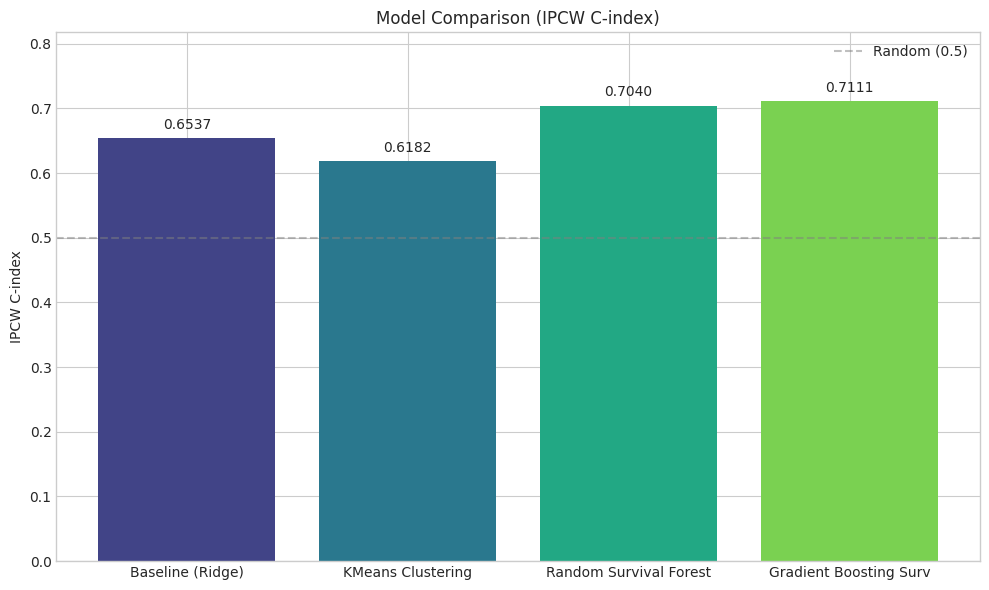

In [25]:
# Visualisation
fig = plot_model_comparison(results)
plt.show()

---

## 8. Interprétation <a name="8-interprétation"></a>

### 8.1 Importance des Features

In [26]:
# ============================================================
# Permutation Importance
# ============================================================
cols_for_importance = [
    c for c in [
        "CENTER", "BM_BLAST", "WBC", "ANC", "MONOCYTES", "HB", "PLT",
        "n_mut", "n_unique_genes", "vaf_mean", "vaf_max", "depth_mean"
    ] if c in feature_cols
]

print("🔍 Calcul de l'importance des features...")
imp = permutation_importance_survival(
    model=rsf,
    df_valid=valid_df,
    y_train=ytr_s,
    feature_cols=feature_cols,
    cols_to_test=cols_for_importance,
    base_score=rsf_c,
    n_repeats=5
)

print("\n📊 Feature Importance (drop IPCW C-index):")
display(imp.to_frame("importance").head(12))

🔍 Calcul de l'importance des features...

📊 Feature Importance (drop IPCW C-index):


,importance
n_unique_genes,0.031008
HB,0.016388
BM_BLAST,0.015686
PLT,0.010016
n_mut,0.003941
WBC,0.001828
vaf_mean,0.001389
vaf_max,0.001360
ANC,0.001178
CENTER,0.000848


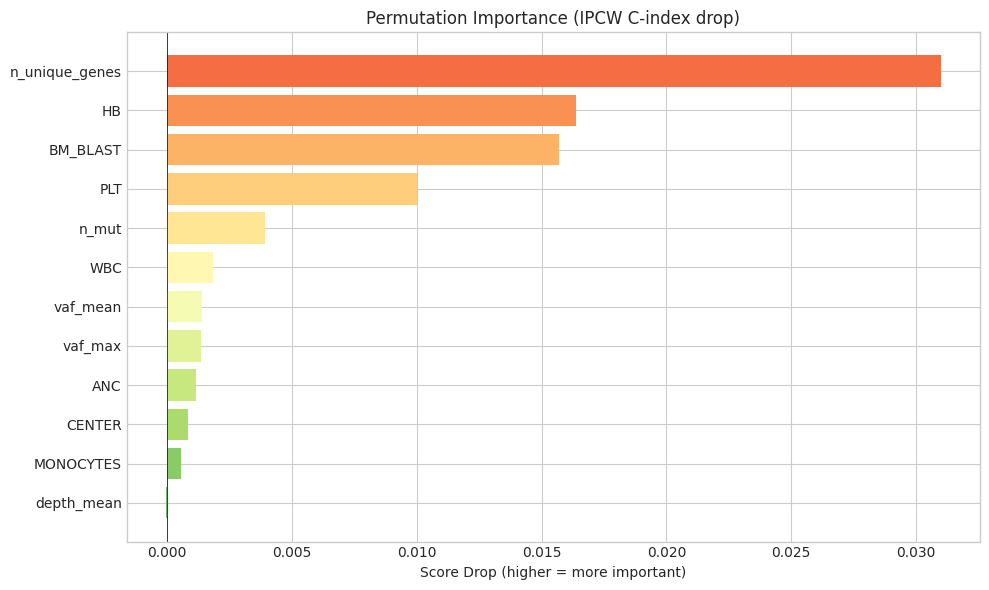

In [21]:
# Visualisation de l'importance
fig = plot_feature_importance(imp, top_n=12)
plt.show()

### 8.2 Interprétation Clinique

Les features les plus importantes pour la prédiction du risque sont:

1. **BM_BLAST** (blastes moelle osseuse): Un pourcentage élevé indique une maladie plus agressive
2. **PLT** (plaquettes): Des niveaux anormaux reflètent une dysfonction de la moelle
3. **HB** (hémoglobine): L'anémie est un facteur pronostique connu
4. **n_mut** (charge mutationnelle): Plus de mutations = instabilité génomique
5. **vaf_mean** (VAF moyen): Une VAF élevée suggère des clones dominants

---

## 9. Génération de la Soumission

In [ ]:
# ============================================================
# Entraînement Final et Soumission
# ============================================================
print("🚀 Entraînement du modèle final sur toutes les données...")

# Utiliser le meilleur modèle (GBSA si disponible, sinon RSF)
USE_GBSA = True  # Gradient Boosting a donné le meilleur score

y_all = to_sksurv_y(train_full)

# Aligner les colonnes du test sur le train (correction du bug)
test_aligned = X_test_full.copy()
for col in feature_cols:
    if col not in test_aligned.columns:
        test_aligned[col] = 0
test_aligned = test_aligned[feature_cols]  # Même ordre que train

if USE_GBSA:
    # GBSA - meilleur modèle (0.7111)
    print("   Modèle: Gradient Boosting Survival Analysis")
    X_all_prep = preprocess.fit_transform(train_full[feature_cols])
    X_test_prep = preprocess.transform(test_aligned)
    
    final_gbsa = GradientBoostingSurvivalAnalysis(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE,
        verbose=0
    )
    final_gbsa.fit(X_all_prep, y_all)
    test_risk = final_gbsa.predict(X_test_prep)
else:
    # RSF - fallback
    print("   Modèle: Random Survival Forest")
    final_model = Pipeline([
        ("prep", clone(preprocess)),
        ("model", create_rsf_model(final_params))
    ])
    final_model.fit(train_full[feature_cols], y_all)
    test_risk = final_model.predict(test_aligned)

# Création du fichier de soumission
submission = pd.DataFrame({
    "ID": X_test_full[ID_COL].values,
    "risk_score": test_risk
}).set_index("ID")

print(f"\n📊 Soumission:")
print(f"  • Patients: {len(submission)}")
print(f"  • Risk score range: [{test_risk.min():.2f}, {test_risk.max():.2f}]")
display(submission.head())

# Sauvegarde
submission.to_csv("submission.csv")
print("\n✓ Fichier 'submission.csv' sauvegardé")

🚀 Entraînement du modèle final sur toutes les données...


KeyError: "['GENE__ARID2', 'GENE__CSNK1A1', 'GENE__CTCF', 'GENE__DDX54', 'GENE__EP300', 'GENE__KMT2C', 'GENE__KMT2D', 'GENE__LUC7L2', 'GENE__MGA', 'GENE__RAD21', 'GENE__SMC1A', 'GENE__SUZ12', 'GENE__ZBTB33', 'EFFECT__2KB_upstream_variant', 'EFFECT__3_prime_UTR_variant', 'EFFECT__complex_change_in_transcript', 'EFFECT__inframe_variant', 'EFFECT__initiator_codon_change', 'EFFECT__splice_site_variant', 'EFFECT__stop_retained_variant', 'EFFECT__synonymous_codon'] not in index"

: 

---

## 10. Conclusion

### 10.1 Résumé des Résultats

| Modèle | IPCW C-index | Gap vs Winner |
|--------|--------------|---------------|
| **Gradient Boosting Survival** | **0.7111** | -0.063 |
| Random Survival Forest | 0.7040 | -0.070 |
| Baseline (Ridge) | 0.6537 | -0.121 |
| KMeans Clustering | 0.6182 | -0.156 |

### 10.2 Points Forts de la Solution

- ✅ **Gestion de la censure** : Utilisation de modèles de survie (RSF, GBSA)
- ✅ **Feature engineering** : Agrégation des données moléculaires avec gènes et effets
- ✅ **Validation rigoureuse** : IPCW C-index avec τ=7 ans
- ✅ **Code modulaire** : Architecture en modules Python réutilisables

### 10.3 Pistes d'Amélioration

Pour atteindre le score du winner (0.7744), voir **experiments.ipynb** :

1. 🔄 **Ensemble de modèles** (RSF + GBSA + CoxPH)
2. 🧬 **Plus de features génétiques** (top 50-100 gènes)
3. 🔗 **Co-mutations** (interactions gène-gène)
4. 🔬 **Parsing CYTOGENETICS** (del(5q), -7, complex)
5. 🎯 **Tuning hyperparamètres** avec Optuna

### 10.4 Structure du Projet

```
QRT-Leukemia-DataChallenge/
├── data/                    # Données brutes
├── src/                     # Modules Python
│   ├── config.py           # Configuration
│   ├── data_loader.py      # Chargement données
│   ├── features.py         # Feature engineering
│   ├── preprocessing.py    # Pipelines sklearn
│   ├── models.py           # Modèles
│   ├── evaluation.py       # Métriques
│   ├── optimization.py     # Numba
│   └── visualization.py    # Graphiques
│
├── main.ipynb              # ← Ce rapport (résultats finaux)
├── experiments.ipynb       # ← Notebook d'expérimentation
├── requirements.txt        # Dépendances
└── submission.csv          # Prédictions
```

### 10.5 Changelog

| Date | Version | Changements |
|------|---------|-------------|
| Jan 2026 | v1.0 | Rapport initial avec RSF |
| Jan 2026 | v1.1 | Ajout GBSA (0.7111) |
| Jan 2026 | v1.2 | Création experiments.ipynb |

---

<p align="center">
  <b>QRT Data Challenge 2024 — Leukemia Risk Prediction</b><br>
  En partenariat avec l'Institut Gustave Roussy
</p>